In [12]:
import os
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plotting style
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.dpi'] = 100

## Setup Paths and Load Results

In [13]:
# Define paths
deriv_dir = "./derivatives/none-reduced"
reg_dir = op.join(deriv_dir, "regression")
fig_dir = op.join(reg_dir, "figures")
os.makedirs(fig_dir, exist_ok=True)

# Load all results CSVs
boot_dim1 = pd.read_csv(op.join(reg_dir, "plsc-reg-boot-dim1-results.csv"))
boot_dim3 = pd.read_csv(op.join(reg_dir, "plsc-reg-boot-dim3-results.csv"))
corr_dim1 = pd.read_csv(op.join(reg_dir, "plsc-reg-corr-dim1-results.csv"))
corr_dim3 = pd.read_csv(op.join(reg_dir, "plsc-reg-corr-dim3-results.csv"))

print("Results loaded successfully!")

Results loaded successfully!


## Filter for Significant Results

In [14]:
# Filter for significant results (p < 0.05)
boot_dim1_sig = boot_dim1[boot_dim1['significant_p05'] == True].copy()
boot_dim3_sig = boot_dim3[boot_dim3['significant_p05'] == True].copy()
corr_dim1_sig = corr_dim1[corr_dim1['significant_p05'] == True].copy()
corr_dim3_sig = corr_dim3[corr_dim3['significant_p05'] == True].copy()

# Add dimension and analysis type for tracking
boot_dim1_sig['dimension'] = 'dim1'
boot_dim1_sig['analysis'] = 'bootstrap'
boot_dim1_sig['y_var'] = 'score'

boot_dim3_sig['dimension'] = 'dim3'
boot_dim3_sig['analysis'] = 'bootstrap'
boot_dim3_sig['y_var'] = 'score'

corr_dim1_sig['dimension'] = 'dim1'
corr_dim1_sig['analysis'] = 'correlation'
corr_dim1_sig['y_var'] = 'rsfc'

corr_dim3_sig['dimension'] = 'dim3'
corr_dim3_sig['analysis'] = 'correlation'
corr_dim3_sig['y_var'] = 'rsfc'

print(f"Significant results found:")
print(f"  Bootstrap Dim1: {len(boot_dim1_sig)}")
print(f"  Bootstrap Dim3: {len(boot_dim3_sig)}")
print(f"  Correlation Dim1: {len(corr_dim1_sig)}")
print(f"  Correlation Dim3: {len(corr_dim3_sig)}")

# Display significant results
if len(boot_dim1_sig) > 0:
    print("\nBootstrap Dim1 significant results:")
    display(boot_dim1_sig[['phyhealth_var', 'var_type', 'p_value']])

if len(boot_dim3_sig) > 0:
    print("\nBootstrap Dim3 significant results:")
    display(boot_dim3_sig[['phyhealth_var', 'var_type', 'p_value']])

if len(corr_dim1_sig) > 0:
    print("\nCorrelation Dim1 significant results:")
    display(corr_dim1_sig[['network', 'phyhealth_var', 'var_type', 'p_value']])

if len(corr_dim3_sig) > 0:
    print("\nCorrelation Dim3 significant results:")
    display(corr_dim3_sig[['network', 'phyhealth_var', 'var_type', 'p_value']])

Significant results found:
  Bootstrap Dim1: 1
  Bootstrap Dim3: 0
  Correlation Dim1: 2
  Correlation Dim3: 1

Bootstrap Dim1 significant results:


,phyhealth_var,var_type,p_value
2,resp_wheeze_yn_y,categorical,0.03748



Correlation Dim1 significant results:


,network,phyhealth_var,var_type,p_value
2,cgc-dt,mctq_msfsc_calc,continuous,0.035161
14,dt-dla,mctq_msfsc_calc,continuous,0.038898



Correlation Dim3 significant results:


,network,phyhealth_var,var_type,p_value
8,dt-smm,blood_pressure_dia_mean,continuous,0.043721


## Define Plotting Function

In [15]:
def plot_regression(data, x_var, y_var, title, save_path, dimension, var_type='continuous'):
    """
    Create a scatter plot with regression line.
    
    Parameters:
    -----------
    data : DataFrame
        Data containing x and y variables
    x_var : str
        Name of x variable (rsfc or score)
    y_var : str
        Name of y variable (physical health measure)
    title : str
        Plot title
    save_path : str
        Path to save the figure
    dimension : str
        Dimension being analyzed (e.g., 'dim1', 'dim3')
    var_type : str
        Type of variable ('continuous' or 'categorical')
    """
    
    # Remove NaN values
    plot_data = data[[x_var, y_var]].dropna()
    
    # Custom labels for specific variables
    custom_labels = {
        'mctq_msfsc_calc': 'Sleep Chronotype',
        'blood_pressure_dia_mean': 'Blood Pressure',
        'resp_wheeze_yn_y': 'Respiratory Problems'
    }
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    if var_type == 'continuous':
        # Scatter plot with regression line
        sns.scatterplot(data=plot_data, x=x_var, y=y_var, alpha=0.5, s=70, ax=ax, 
                       color='#737373', edgecolor='white', linewidth=.4)
        
        # Add regression line
        sns.regplot(data=plot_data, x=x_var, y=y_var, 
                   scatter=False, color='#5695D4', line_kws={'linewidth': 2}, ax=ax)
        
        # Calculate correlation and p-value
        r, p = stats.pearsonr(plot_data[x_var], plot_data[y_var])
        print(f"  {dimension}: r = {r:.3f}, p = {p:.4f}, n = {len(plot_data)}")
        # Print statistics
        print(f"  r = {r:.3f}, p = {p:.4f}, n = {len(plot_data)}")
    
    else:  # categorical
        # Horizontal box plot with individual points (categorical var on y-axis)
        palette = ['#113147', '#5695D4']  # Colors for each category
        
        # Remap 0.0 to "No" and 1.0 to "Yes"
        plot_data[y_var] = plot_data[y_var].map({0.0: 'No', 1.0: 'Yes'})
        
        sns.boxplot(data=plot_data, x=x_var, y=y_var, ax=ax, palette=palette, orient='h', 
                    boxprops=dict(alpha=0.7), whiskerprops=dict(alpha=1.0), 
                    capprops=dict(alpha=1.0), medianprops=dict(alpha=1.0))
        sns.stripplot(data=plot_data, x=x_var, y=y_var, 
                     color="#737373", alpha=0.5, size=9, ax=ax, orient='h',
                     edgecolor='white', linewidth=.4)
        print(f"  {dimension}: n = {len(plot_data)}")
        # Print sample size
        print(f"  n = {len(plot_data)}")
    
    ax.set_xlabel(x_var.upper() if x_var == 'rsfc' else 'Latent Score', fontsize=12)
    y_label = custom_labels.get(y_var, y_var.replace('_', ' ').title())
    ax.set_ylabel(y_label, fontsize=12)
    
    # Update title with custom label if applicable
    if y_var in custom_labels:
        title = title.replace(y_var.replace('_', ' ').title(), custom_labels[y_var])
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Saved: {save_path}")

## Generate Plots for Bootstrap Results (Latent Scores)

  dim1: n = 171
  n = 171


/var/folders/x1/rzvtxb3x273_5fvyk8ftl70r0000gn/T/ipykernel_96115/938771445.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x=x_var, y=y_var, ax=ax, palette=palette, orient='h',


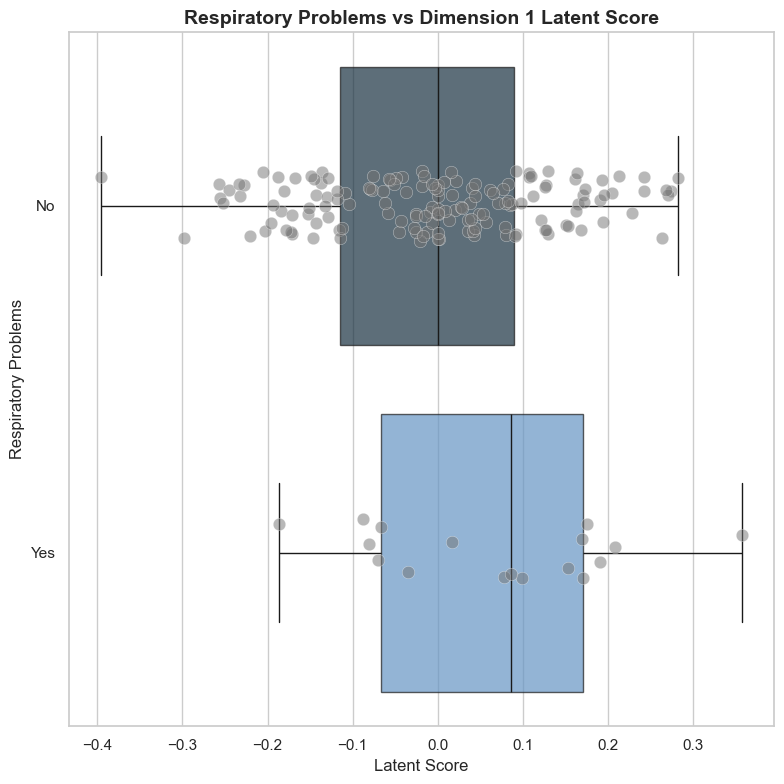

Saved: ./derivatives/none-reduced/regression/figures/bootstrap_dim1_resp_wheeze_yn_y.png


In [16]:
# Process bootstrap results (latent scores)
for boot_sig in [boot_dim1_sig, boot_dim3_sig]:
    if len(boot_sig) == 0:
        continue
    
    for idx, row in boot_sig.iterrows():
        dim = row['dimension']
        phyhealth_var = row['phyhealth_var']
        var_type = row['var_type']
        p_value = row['p_value']
        
        # Construct data file path
        data_file = op.join(reg_dir, dim, f"phyhealth_{dim}_data.csv")
        
        if not op.exists(data_file):
            print(f"Warning: Data file not found: {data_file}")
            continue
        
        # Load data
        data = pd.read_csv(data_file)
        
        # Create plot title
        dim_num = dim.replace('dim', '')
        title = f"{phyhealth_var.replace('_', ' ').title()} vs Dimension {dim_num} Latent Score"
        
        # Create save path
        save_name = f"bootstrap_{dim}_{phyhealth_var}.png"
        save_path = op.join(fig_dir, save_name)
        
        # Generate plot
        plot_regression(data, 'score', phyhealth_var, title, save_path, dim, var_type)

## Generate Plots for Correlation Results (RSFC Networks)

  dim1: r = 0.063, p = 0.4135, n = 171
  r = 0.063, p = 0.4135, n = 171


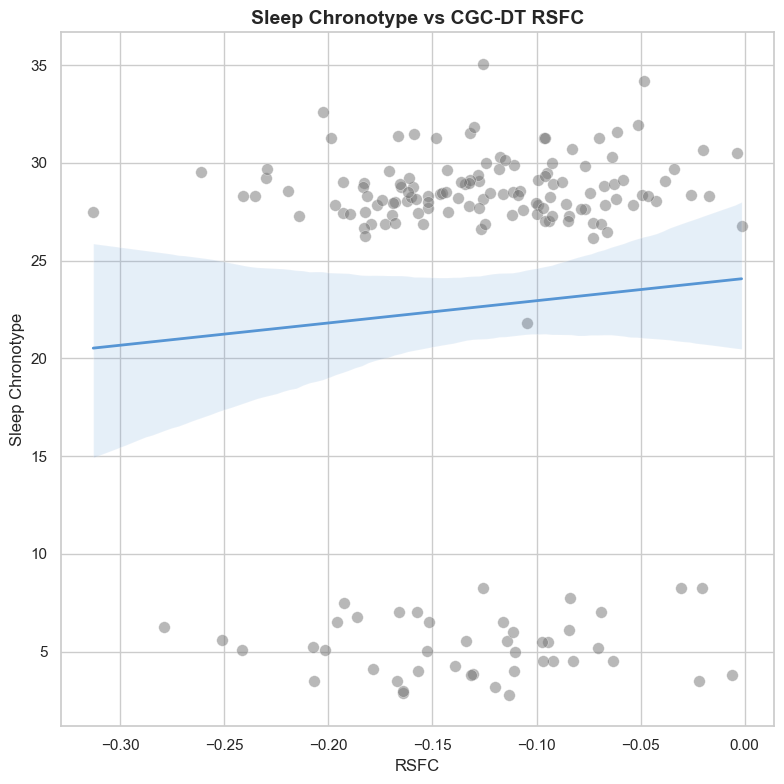

Saved: ./derivatives/none-reduced/regression/figures/correlation_dim1_cgc-dt_mctq_msfsc_calc.png
  dim1: r = 0.067, p = 0.3822, n = 171
  r = 0.067, p = 0.3822, n = 171


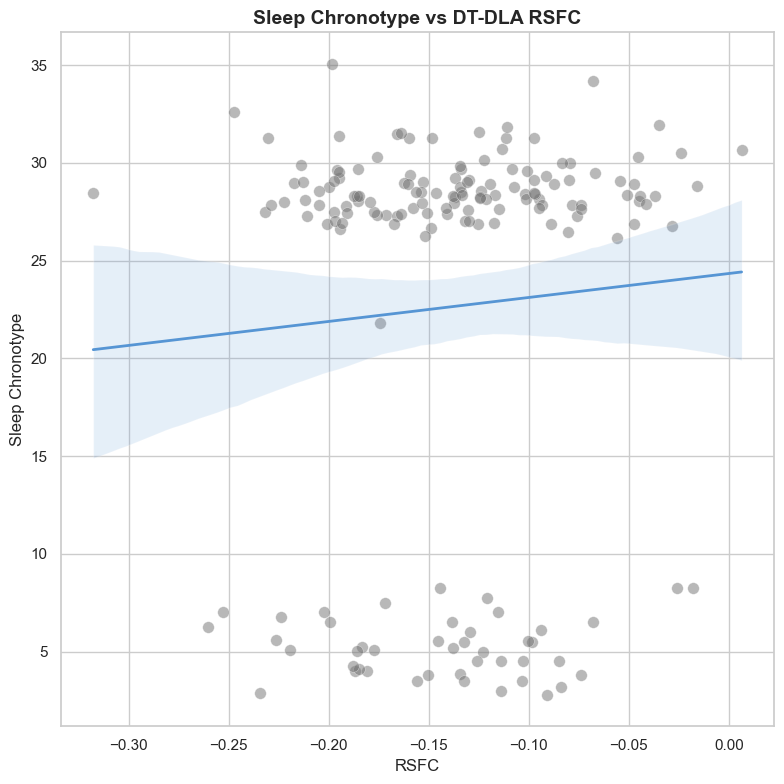

Saved: ./derivatives/none-reduced/regression/figures/correlation_dim1_dt-dla_mctq_msfsc_calc.png
  dim3: r = -0.134, p = 0.0799, n = 171
  r = -0.134, p = 0.0799, n = 171


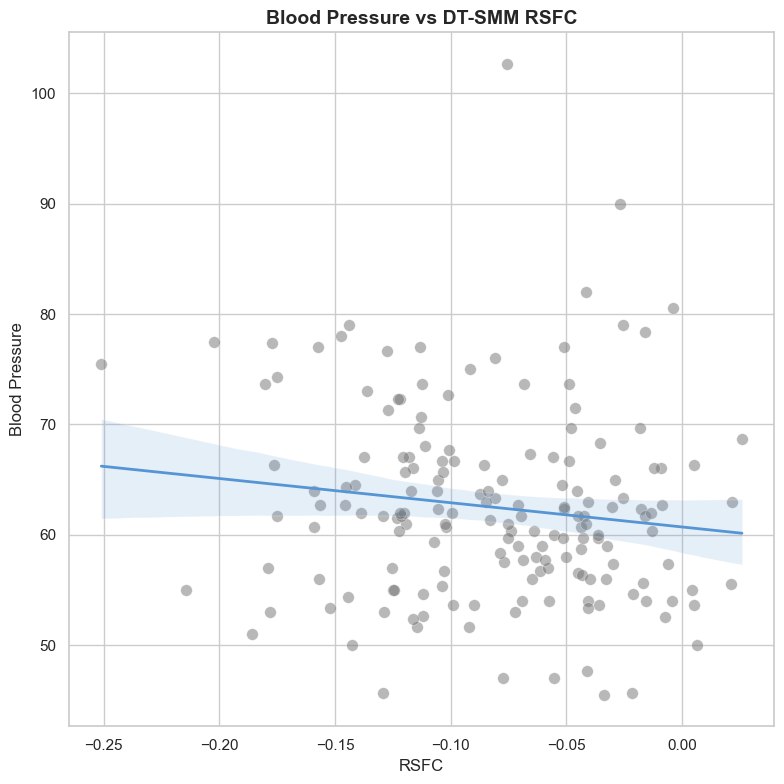

Saved: ./derivatives/none-reduced/regression/figures/correlation_dim3_dt-smm_blood_pressure_dia_mean.png


In [17]:
# Process correlation results (rsfc networks)
for corr_sig in [corr_dim1_sig, corr_dim3_sig]:
    if len(corr_sig) == 0:
        continue
    
    for idx, row in corr_sig.iterrows():
        dim = row['dimension']
        network = row['network']
        phyhealth_var = row['phyhealth_var']
        var_type = row['var_type']
        p_value = row['p_value']
        
        # Construct data file path
        data_file = op.join(reg_dir, dim, f"phyhealth_{network}_data.csv")
        
        if not op.exists(data_file):
            print(f"Warning: Data file not found: {data_file}")
            continue
        
        # Load data
        data = pd.read_csv(data_file)
        
        # Create plot title
        title = f"{phyhealth_var.replace('_', ' ').title()} vs {network.upper()} RSFC"
        
        # Create save path
        save_name = f"correlation_{dim}_{network}_{phyhealth_var}.png"
        save_path = op.join(fig_dir, save_name)
        
        # Generate plot
        plot_regression(data, 'rsfc', phyhealth_var, title, save_path, dim, var_type)

## Summary

In [18]:
# Count total plots generated
total_plots = len(boot_dim1_sig) + len(boot_dim3_sig) + len(corr_dim1_sig) + len(corr_dim3_sig)

print(f"\n{'='*60}")
print(f"SUMMARY")
print(f"{'='*60}")
print(f"Total significant results plotted: {total_plots}")
print(f"Figures saved to: {fig_dir}")
print(f"{'='*60}")


SUMMARY
Total significant results plotted: 4
Figures saved to: ./derivatives/none-reduced/regression/figures
